In [1]:
# importing libraries

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
online_transactions = pd.read_pickle('../data/data_prepared_for_analysis.pkl')

# RFM Analysis

The RFM (Recency, Frequency, Monetary) score method is used in my customer segmentation and analysis to evaluate and rank customers based on their behavior and transaction history.

In [3]:
# Recency calculation

transaction_recency = online_transactions.groupby(by='customer_id', as_index=False)['invoice_date'].max()
transaction_recency.columns = ['customer_id','last_purchase_date']
recent_date = transaction_recency['last_purchase_date'].max()
transaction_recency['recency'] = transaction_recency['last_purchase_date'].apply(lambda x: (recent_date - x).days)
transaction_recency.head()

,customer_id,last_purchase_date,recency
0,u12347,2011-12-07 15:52:00,1
1,u12348,2011-09-25 13:13:00,74
2,u12349,2011-11-21 09:51:00,18
3,u1235,2011-02-02 16:01:00,309
4,u12352,2011-11-03 14:37:00,35


In [4]:
# Frequency calculation

transaction_frequency = online_transactions.groupby(by='customer_id', as_index=False)['invoice_date'].nunique()
transaction_frequency.columns = ['customer_id','frequency']
transaction_frequency.head()

,customer_id,frequency
0,u12347,7
1,u12348,4
2,u12349,1
3,u1235,1
4,u12352,8


In [5]:
# Monetary value calculation

transaction_monetary = online_transactions.groupby(by='customer_id', as_index=False).total_order_value.sum()
transaction_monetary.columns = ['customer_id','monetary']
transaction_monetary.head()

,customer_id,monetary
0,u12347,4310.00
1,u12348,1437.24
2,u12349,1457.55
3,u1235,294.40
4,u12352,1265.41


In [6]:
transaction_rf = pd.merge(transaction_recency, transaction_frequency, on='customer_id', how='inner')
transaction_rfm = pd.merge(transaction_rf, transaction_monetary, on='customer_id', how="inner").drop(columns='last_purchase_date')
transaction_rfm.head()

,customer_id,recency,frequency,monetary
0,u12347,1,7,4310.00
1,u12348,74,4,1437.24
2,u12349,18,1,1457.55
3,u1235,309,1,294.40
4,u12352,35,8,1265.41


In [7]:
# Ranking customers based on recency, frequency, monetary

transaction_rfm['r_rank'] = transaction_rfm['recency'].rank(ascending=False)
transaction_rfm['f_rank'] = transaction_rfm['frequency'].rank(ascending=True)
transaction_rfm['m_rank'] = transaction_rfm['monetary'].rank(ascending=True)

In [8]:
transaction_rfm.head()

,customer_id,recency,frequency,monetary,r_rank,f_rank,m_rank
0,u12347,1,7,4310.00,4171.0,3529.0,4005.0
1,u12348,74,4,1437.24,1612.0,2782.5,3132.0
2,u12349,18,1,1457.55,3106.5,652.0,3144.0
3,u1235,309,1,294.40,223.0,652.0,1058.0
4,u12352,35,8,1265.41,2457.0,3661.0,2983.0


In [9]:
# Normalizing the rank of the customer

transaction_rfm['r_rank_norm'] = (transaction_rfm['r_rank']/transaction_rfm['r_rank'].max())*100
transaction_rfm['f_rank_norm'] = (transaction_rfm['f_rank']/transaction_rfm['f_rank'].max())*100
transaction_rfm['m_rank_norm'] = (transaction_rfm['m_rank']/transaction_rfm['m_rank'].max())*100

transaction_rfm.drop(columns=['r_rank','f_rank','m_rank'], inplace=True)
transaction_rfm.head()

,customer_id,recency,frequency,monetary,r_rank_norm,f_rank_norm,m_rank_norm
0,u12347,1,7,4310.00,97.715825,81.689815,92.708333
1,u12348,74,4,1437.24,37.765023,64.409722,72.500000
2,u12349,18,1,1457.55,72.777322,15.092593,72.777778
3,u1235,309,1,294.40,5.224318,15.092593,24.490741
4,u12352,35,8,1265.41,57.561204,84.745370,69.050926


I am using different weights of coefficients for the Recency, Frequency, and Monetary **(0.2:0.3:0.5)** to prioritize loyal customers with high purchase values.

In [10]:
# RFM score calculation based on RFM score=(0.2*recency score)+(0.3*frequency score)+(0.5*monetary)
# Rate on a scale of 5

transaction_rfm['rfm_score'] = (0.2*transaction_rfm['r_rank_norm']) + \
                                (0.3*transaction_rfm['f_rank_norm']) + \
                                (0.5*transaction_rfm['m_rank_norm'])
transaction_rfm['rfm_score'] = round(transaction_rfm['rfm_score']*0.05,1)
transaction_rfm[['customer_id','rfm_score']].head()

,customer_id,rfm_score
0,u12347,4.5
1,u12348,3.2
2,u12349,2.8
3,u1235,0.9
4,u12352,3.6


## Rankung customers

**Top Customers (RFM Score > 4.5):** 

The threshold for recency (R) is set high to identify customers who have made very recent purchases. These are customers who are actively engaged with the business.
The threshold for frequency (F) is set high to identify customers who make purchases frequently. This indicates consistent loyalty.
The threshold for monetary (M) score is set high to identify customers who spend a significant amount on their purchases. These are typically high-value customers.
Rationale: The goal is to identify the most valuable and engaged customers who have the potential to contribute significantly to the business's revenue.

**High-Value Customers (4.5 > RFM Score > 4.0):**

The thresholds for recency (R), frequency (F), and monetary (M) scores are slightly lower than for top customers but still relatively high.
Rationale: This segment includes customers who may not be as engaged as top customers but still have a high average spend and moderate engagement.

**Medium-Value Customers (4 > RFM Score > 3):**

The thresholds for recency (R), frequency (F), and monetary (M) scores are set at a moderate level.
Rationale: This segment includes customers with average engagement and spending. They may have potential for growth with targeted marketing efforts.

**Low-Value Customers (3 > RFM Score > 1.5):**

The thresholds for recency (R), frequency (F), and monetary (M) scores are set at relatively low levels.
Rationale: This segment includes customers who are less engaged and have lower spending habits. They may require more effort to increase their engagement and spending.

**Lost Customers (RFM Score < 1.5):**

The thresholds for recency (R), frequency (F), and monetary (M) scores are set very low.
Rationale: These customers have disengaged from the business and represent a significant risk of being lost permanently. Identifying them allows for reactivation efforts.

In [11]:
transaction_rfm['customer_segmentation'] = np.where(transaction_rfm['rfm_score'] > 4.5, 'top_customer', \
                                            np.where(transaction_rfm['rfm_score'] > 4.0, 'high_value_customer', \
                                            np.where(transaction_rfm['rfm_score'] > 3.0, 'medium_value_customer', \
                                            np.where(transaction_rfm['rfm_score'] > 1.5, 'low_value_customer', \
                                            'lost_customer'))))
transaction_rfm[['customer_id','rfm_score','customer_segmentation']].head()

,customer_id,rfm_score,customer_segmentation
0,u12347,4.5,high_value_customer
1,u12348,3.2,medium_value_customer
2,u12349,2.8,low_value_customer
3,u1235,0.9,lost_customer
4,u12352,3.6,medium_value_customer


In [12]:
# adding customer segmentation to the original dataset

customer_set_w_segments = pd.merge(online_transactions, transaction_rfm, on='customer_id', how='left')

customer_set_w_segments.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,recency,frequency,monetary,r_rank_norm,f_rank_norm,m_rank_norm,rfm_score,customer_segmentation
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,1.25,24,30.00,2010-12-01 08:45:00,u12583,France,2,17,6629.34,95.490219,95.462963,96.087963,4.8,top_customer
1,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,19.95,1,19.95,2010-12-01 09:56:00,u1742,United Kingdom,49,3,598.83,50.286986,54.340278,46.875000,2.5,low_value_customer
2,536392,22128,PARTY CONES CANDY ASSORTED,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom,7,3,711.86,87.560033,54.340278,53.101852,3.0,low_value_customer
3,536404,22469,HEART OF WICKER SMALL,1.65,12,19.80,2010-12-01 11:29:00,u16218,United Kingdom,29,8,3054.87,62.152981,84.745370,88.055556,4.1,high_value_customer
4,536412,22274,FELTCRAFT DOLL EMILY,2.95,2,5.90,2010-12-01 11:49:00,u1792,United Kingdom,3,17,4107.60,92.854633,95.462963,92.384259,4.7,top_customer


### Distribution of Customers Number and Revenue by Segmentation


In [13]:
segments = (customer_set_w_segments.groupby('customer_segmentation')
            .agg(sum_total_order_value=('total_order_value', 'sum'),
                 customers_cnt=('customer_id', 'nunique'))
            .reset_index())
segments

,customer_segmentation,sum_total_order_value,customers_cnt
0,high_value_customer,1439633.310,387
1,lost_customer,271259.841,1250
2,low_value_customer,979922.181,1489
3,medium_value_customer,1712919.891,945
4,top_customer,3883892.610,249


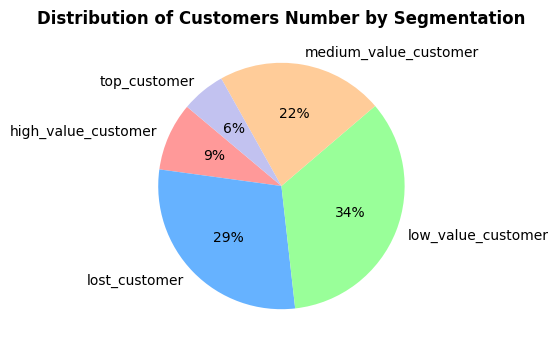

In [14]:
# Extract the values for the pie chart
values = segments['customers_cnt']
labels = segments['customer_segmentation']
custom_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0']

# Plotting the pie chart
plt.figure(figsize=(6, 4))
plt.pie(values, labels=labels, autopct='%.0f%%', startangle=140, colors=custom_colors)
plt.title('Distribution of Customers Number by Segmentation', fontweight = 'bold')

plt.show()

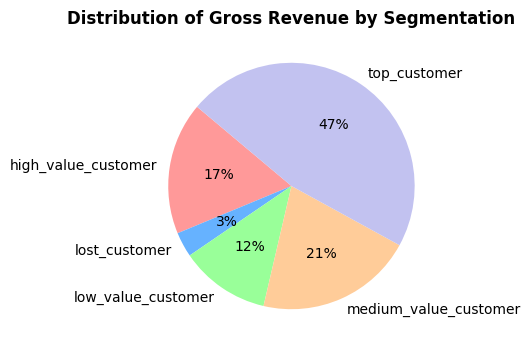

In [15]:
# Extract the values for the pie chart
values = segments['sum_total_order_value']
labels = segments['customer_segmentation']

# Plotting the pie chart
plt.figure(figsize=(6, 4))
plt.pie(values, labels=labels, autopct='%.0f%%', startangle=140, colors=custom_colors)
plt.title('Distribution of Gross Revenue by Segmentation', fontweight = 'bold')

plt.show()

## First thoughts based on the segmentation analysis:

 - A relatively small percentage, specifically 6% of all customers, contribute significantly, accounting for 47% of the total gross revenue.

- The largest customer segment, comprising 34% of the total, falls into the "Low-Value Customers" category. These customers are at a higher risk of transitioning into the "Lost Customers" segment. To mitigate this risk, we should focus on strategies to migrate them to the "Medium-Value Customers" category.

### Comparing segments data

In [16]:
# creating a DataFrame summarizing information about segments

segments_description = customer_set_w_segments.groupby('customer_segmentation').agg(
    customer_cnt=('customer_id', 'nunique'),
    invoice_cnt=('invoice', 'nunique'),
    avg_price=('price', lambda x: round(x.mean(), 2)), 
    avg_quantity=('quantity', lambda x: round(x.mean())),
    total_orders_value=('total_order_value', lambda x: round(x.sum())),
    country_cnt=('country','nunique'),
    avg_recency=('recency', lambda x: round(x.mean())),
    avg_frequency=('frequency', lambda x: round(x.mean())),
    avg_monetary=('monetary', lambda x: round(x.mean())), 
    avg_rfm_score=('rfm_score', lambda x: round(x.mean(),1))
).reset_index().sort_values(by='avg_rfm_score', ascending=False)
segments_description

,customer_segmentation,customer_cnt,invoice_cnt,avg_price,avg_quantity,total_orders_value,country_cnt,avg_recency,avg_frequency,avg_monetary,avg_rfm_score
4,top_customer,249,6903,3.07,18,3883893,13,4,60,32171,4.8
0,high_value_customer,387,4113,2.81,10,1439633,18,15,11,3960,4.3
3,medium_value_customer,945,5389,2.93,10,1712920,23,41,6,1912,3.6
2,low_value_customer,1489,3802,2.95,9,979922,31,82,3,737,2.4
1,lost_customer,1250,1519,2.99,8,271260,24,175,1,255,1.1


## Based on this segmentation, here are some suggestions:

- **Top Customer Segment - 6%**: These are your most valuable customers with a high average monetary value and RFM score. Continue providing excellent service and possibly consider loyalty programs to maintain their loyalty.

- **High-Value Customer Segment - 9%**: While not as high in monetary value as the top segment, these customers have a high frequency and recency. Focus on retaining them and offering personalized experiences.

- **Medium-Value Customer Segment - 22%**: These customers have good potential for growth. Consider strategies to increase their average monetary value and frequency.

- **Low-Value Customer Segment - 34%**: Although they have the largest customer count, their average monetary value is low. You need to explore ways to upsell and convert them into higher-value segments.

- **Lost Customer Segment - 29%**: These are customers who haven't made recent purchases. Implement win-back strategies to re-engage them, possibly with special offers or incentives.

In [17]:
# saving dataset with customer segments

customer_set_w_segments.to_pickle('../data/customer_segment_data.pkl')